In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import umap
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

/Users/denvirhiggins/anaconda3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/denvirhiggins/anaconda3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/denvirhiggins/anaconda3/lib/python3.11/site-packages/umap/distances.py:

## Reading in data and preparing it for ML

In [2]:
## Load in data and labels
data=np.load('../../data/debug_birdclef2025_melspec_5sec_256_256.npy',allow_pickle=True)
debug_dict=data.item()
labels=pd.read_csv('../../data/raw/birdclef-2025/taxonomy.csv')

# for key, array in debug_dict.items():
#     print(f'Key: {key}, Shape: {array.shape}, Dtype: {array.dtype}')

In [3]:
id_to_class = dict(zip(labels['primary_label'].astype(str), labels['class_name']))

X = []
y = []

for key, img in debug_dict.items():
    id_part = key.split('-')[0]
    class_name = id_to_class.get(id_part)
    if class_name:
        X.append(img)
        y.append(class_name)

X = np.array(X)
y = np.array(y)

## EDA for pre-processed spectrogram

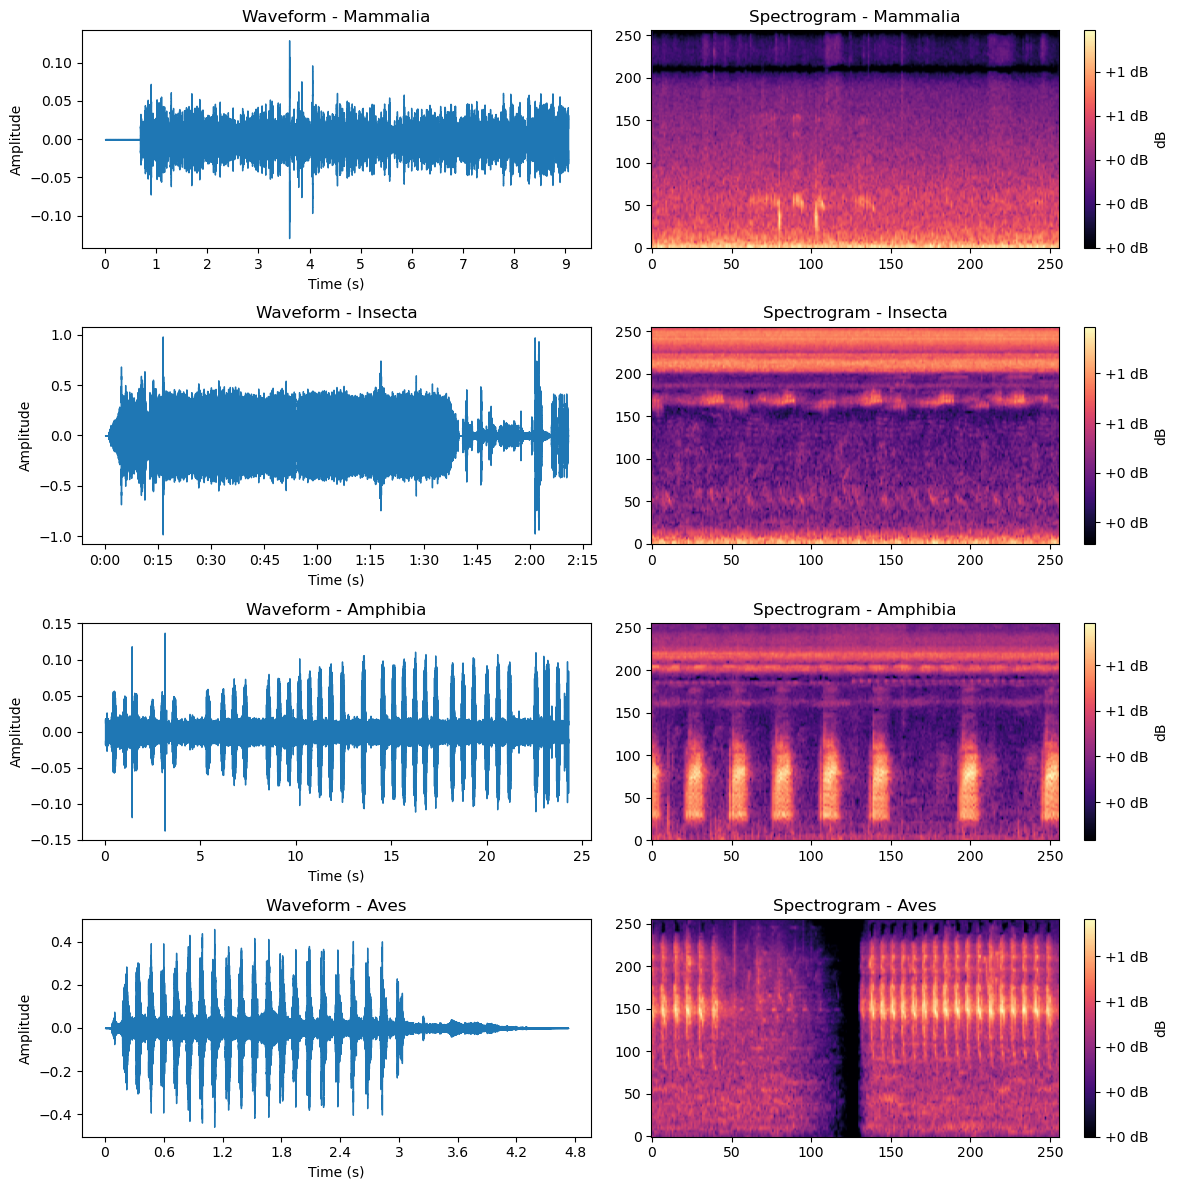

In [4]:
## Create spectrogram and waveform plots
keys = list(debug_dict.keys())
species_per_key = dict(zip(keys, y))

unique_species = list(set(y))
selected_keys = []

for species in unique_species:
    matching_keys = [k for k in keys if species_per_key[k] == species]
    if matching_keys:
        selected_keys.append(random.choice(matching_keys))

fig, axs = plt.subplots(len(selected_keys), 2, figsize=(12, 3 * len(selected_keys)))

if len(selected_keys) == 1:
    axs = np.expand_dims(axs, axis=0) 

for i, key in enumerate(selected_keys):
    species = species_per_key[key]
    id_part, instance = key.split('-')
    audio_path = f'../../data/raw/birdclef-2025/train_audio/{id_part}/{instance}.ogg'

    # Load waveform
    ysr, sr = librosa.load(audio_path, sr=None)

    # Get spectrogram
    spec = debug_dict[key]

    # Plot waveform
    librosa.display.waveshow(ysr, sr=sr, ax=axs[i, 0])
    axs[i, 0].set_title(f"Waveform - {species}")
    axs[i, 0].set_xlabel("Time (s)")
    axs[i, 0].set_ylabel("Amplitude")

    # Plot spectrogram
    img = axs[i, 1].imshow(spec, aspect='auto', origin='lower', cmap='magma')
    axs[i, 1].set_title(f"Spectrogram - {species}")
    fig.colorbar(img, ax=axs[i, 1], format='%+2.0f dB', label="dB")

plt.tight_layout()
plt.show()


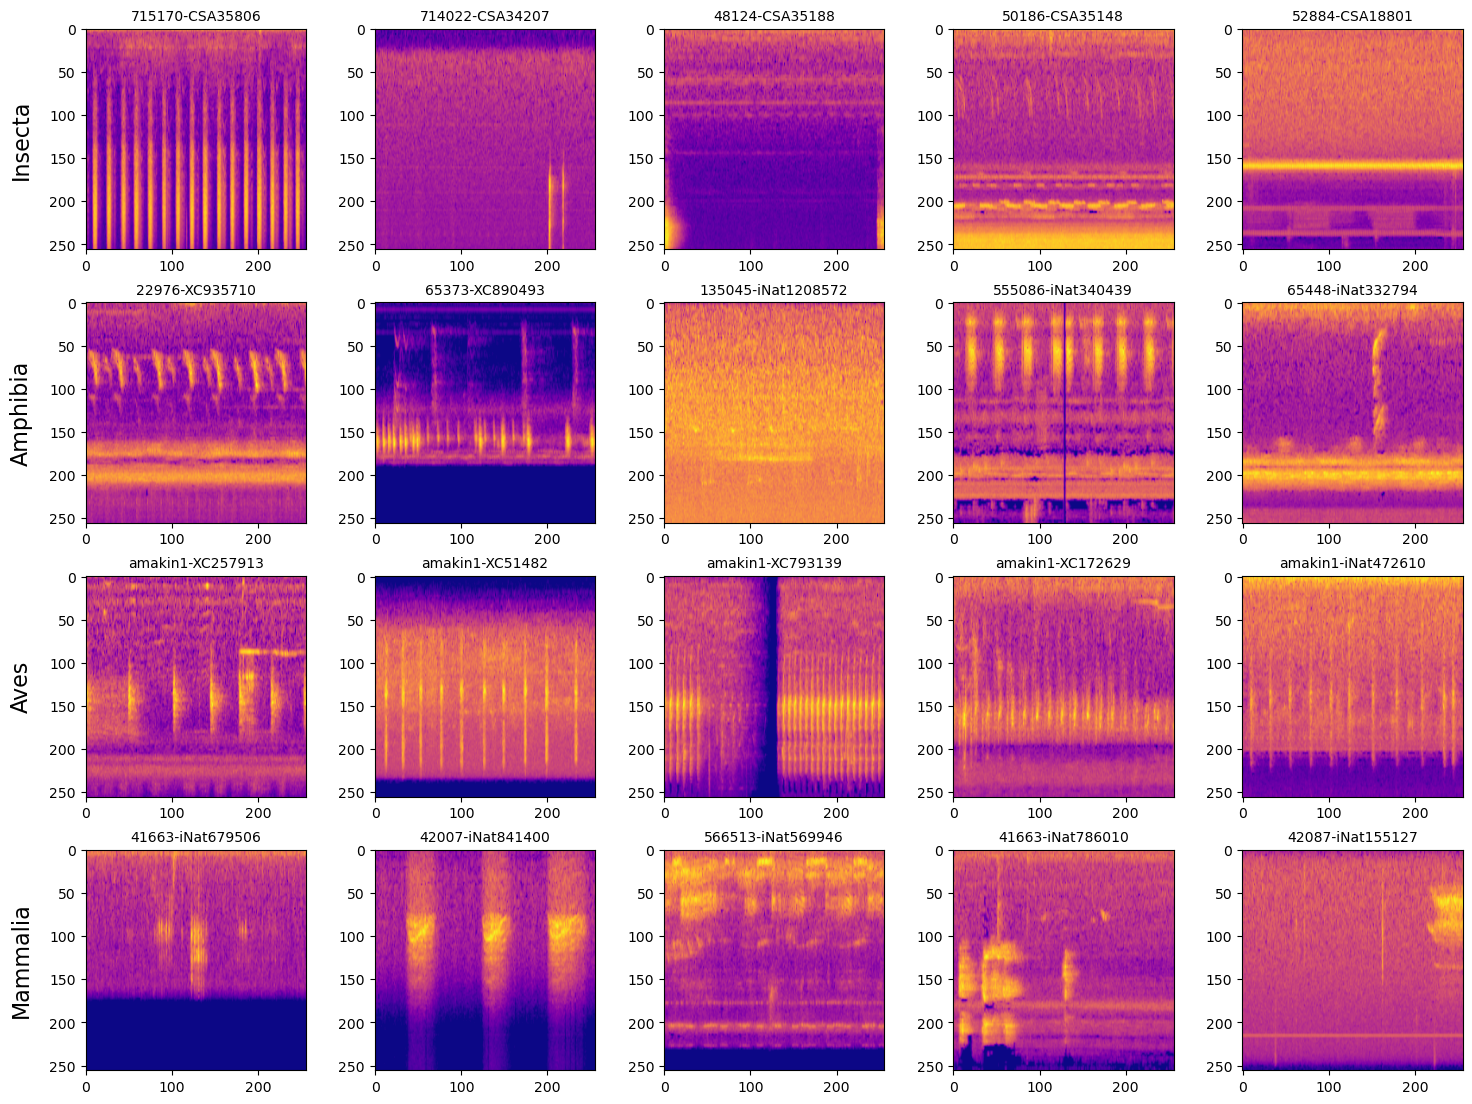

In [7]:
## Load in data and labels
data=np.load('../../data/debug_birdclef2025_melspec_5sec_256_256.npy',allow_pickle=True)
debug_dict=data.item()
labels=pd.read_csv('../../data/raw/birdclef-2025/taxonomy.csv')

# for key, array in debug_dict.items():
#     print(f'Key: {key}, Shape: {array.shape}, Dtype: {array.dtype}')

## Create visualization of random sample of spectrograms
id_to_class = dict(zip(labels['primary_label'].astype(str), labels['class_name']))

class_to_keys = {}

for key in debug_dict:
    id_part = key.split('-')[0] 
    class_name = id_to_class.get(id_part)
    if class_name:
        class_to_keys.setdefault(class_name, []).append(key)

fig, axs = plt.subplots(4, 5, figsize=(15, 12))
desired_classes = ['Insecta', 'Amphibia', 'Aves', 'Mammalia']

for row, cls in enumerate(desired_classes):
    keys = class_to_keys.get(cls, [])
    
    if not keys:
        for col in range(4):
            axs[row, col].axis('off')
        continue

    sampled = random.sample(keys, min(5, len(keys)))

    for col in range(5):
        ax = axs[row, col]
        if col < len(sampled):
            key = sampled[col]
            img = debug_dict[key]
            ax.imshow(img, cmap='plasma')
            ax.set_title(key, fontsize=10)
        else:
            ax.axis('off')
        if col == 0:
            ax.set_ylabel(cls, fontsize=16, rotation=90, labelpad=20, va='center')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

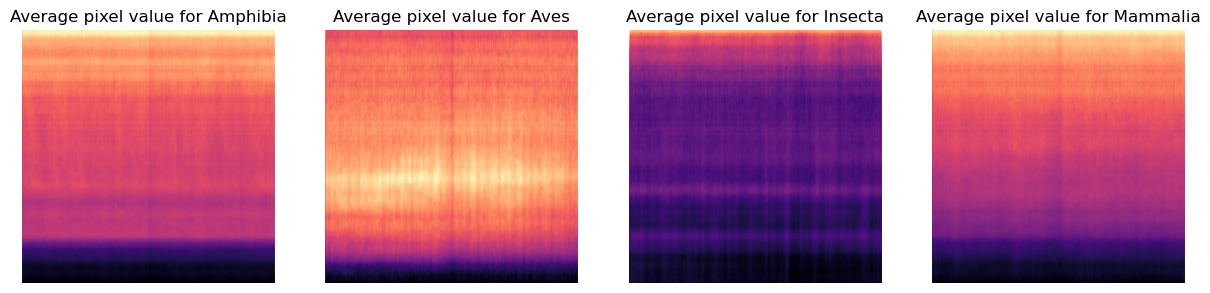

In [8]:
## Checking average sound per species
species = np.unique(y)
fig, axs = plt.subplots(1, len(species), figsize=(15, 5))

for i, sp in enumerate(species):
    avg_img = np.mean([img for img, label in zip(X, y) if label == sp], axis=0)
    axs[i].imshow(avg_img, cmap='magma')
    axs[i].set_title(f"Average pixel value for {sp}")
    axs[i].axis('off')
plt.show()

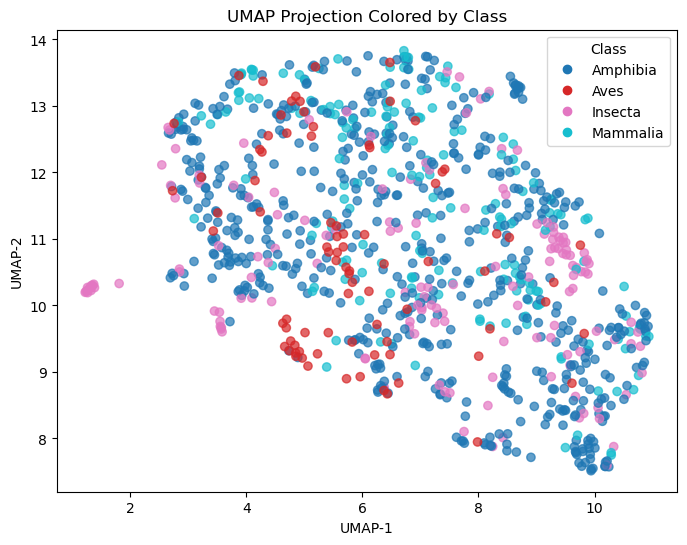

In [9]:
X_flat = X.reshape(X.shape[0], -1)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_flat)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_encoded, cmap='tab10', alpha=0.7)

# Add legend with class names
handles = [plt.Line2D([], [], marker='o', linestyle='', color=scatter.cmap(scatter.norm(i)))
           for i in range(len(le.classes_))]
plt.legend(handles, le.classes_, title="Class", loc="best")

plt.title("UMAP Projection Colored by Class")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

Text(0.5, 1.0, 'Pixel Intensity Distribution per Class')

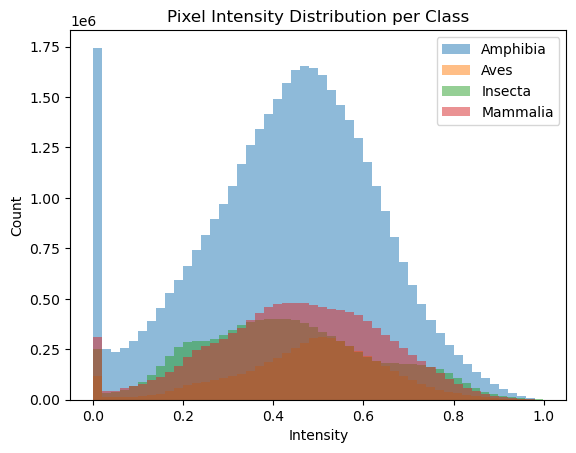

In [10]:
## Pixel intensity per species
for cls in np.unique(y):
    imgs = [img for img, label in zip(X, y) if label == cls]
    intensities = np.array(imgs).flatten()
    plt.hist(intensities, bins=50, alpha=0.5, label=cls)
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.legend()
plt.title("Pixel Intensity Distribution per Class")

## Baseline model creation

In [11]:
## Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'X_train shape: {X_train.shape}')
print(f'X_train type: {type(X_train)}')

print(f'Y_train shape: {y_train.shape}')
print(f'Y_train shape: {type(y_train)}')

print(f'X_test shape: {X_test.shape}')
print(f'X_test shape: {type(X_test)}')

print(f'Y_test shape: {y_test.shape}')
print(f'Y_test shape: {type(y_test)}')

X_train shape: (800, 256, 256)
X_train type: <class 'numpy.ndarray'>
Y_train shape: (800,)
Y_train shape: <class 'numpy.ndarray'>
X_test shape: (200, 256, 256)
X_test shape: <class 'numpy.ndarray'>
Y_test shape: (200,)
Y_test shape: <class 'numpy.ndarray'>


In [12]:
## Flatten to prepare for model
X_train = X_train.reshape(X_train.shape[0], 256 * 256)
X_test = X_test.reshape(X_test.shape[0], 256 * 256)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (800, 65536)
X_test shape: (200, 65536)


In [13]:
## Shuffling the data
np.random.seed(0)
shuffled_indices = np.random.permutation(X_train.shape[0])

X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

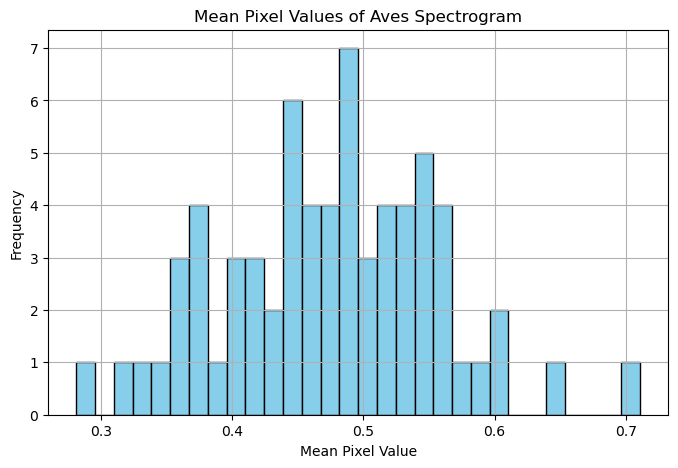

Mean pixel value across all aves spectrograms: 0.4747


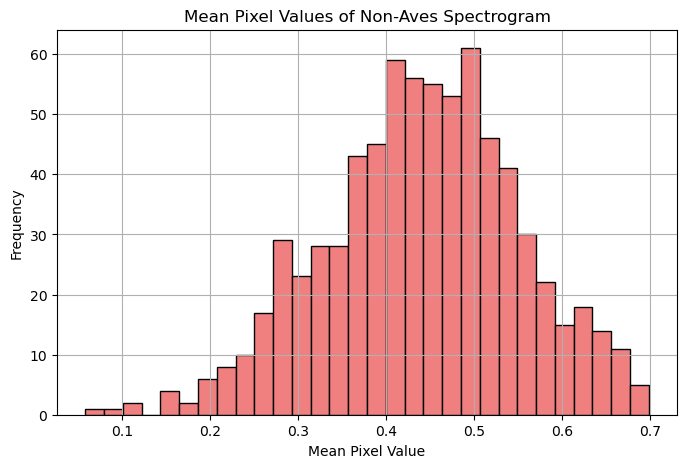

Mean pixel value across all non-aves spectrograms: 0.4406


In [14]:
## Creating a baseline model
y_train = np.copy(y_train)
y_test = np.copy(y_test)

y_train = (y_train == 'Aves').astype(int)
y_test = (y_test == 'Aves').astype(int)

# looking at aves images and mean pixel value
aves_indices = np.where(y_train == 1)[0]
aves_images = X_train[aves_indices]
aves_means = aves_images.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(aves_means, bins=30, color='skyblue', edgecolor='black')
plt.title('Mean Pixel Values of Aves Spectrogram')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Mean pixel value across all aves spectrograms: {np.mean(aves_means):.4f}")

# looking at other images and mean pixel value
non_aves_indices = np.where(y_train == 0)[0]
non_aves_images = X_train[non_aves_indices]
non_aves_means = non_aves_images.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(non_aves_means, bins=30, color='lightcoral', edgecolor='black')
plt.title('Mean Pixel Values of Non-Aves Spectrogram')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Mean pixel value across all non-aves spectrograms: {np.mean(non_aves_means):.4f}")

# Baseline seems to indicate the aves values are higher than average

In [16]:
## Building baseline
num_aves = np.sum(y_train == 1)
print(f"Number of aves images: {num_aves}")

num_non_aves = np.sum(y_train== 0)
print(f"Number of non-aves images: {num_non_aves}")

majority_class = 1 if num_aves > num_non_aves else 0
print(f"Majority class: {majority_class}")

majority_predictions = np.full(y_train.shape, majority_class)
accuracy = np.mean(majority_predictions == y_train)
print(f"Accuracy of majority class classifier: {accuracy:.4f}")

def log_loss(y_true, y_pred_proba, eps=1e-15):
    y_pred_proba = np.clip(y_pred_proba, eps, 1 - eps)
    loss = -np.mean(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba))
    return loss

baseline_prob = 0.47

train_log_loss = log_loss(y_train, baseline_prob)
print(f"Log Loss on training data: {train_log_loss:.4f}")

# Baseline model had high accuracy

Number of aves images: 67
Number of non-aves images: 733
Majority class: 0
Accuracy of majority class classifier: 0.9163
Log Loss on training data: 0.6449


[[733   0]
 [ 67   0]]


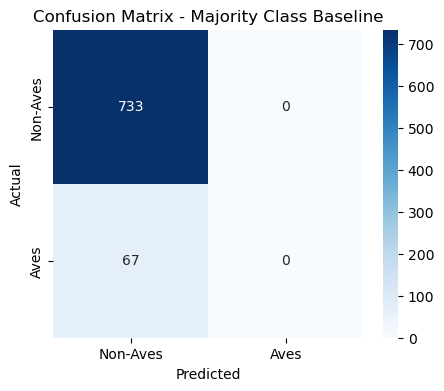

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, majority_predictions)
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

labels = ['Non-Aves', 'Aves']
cm = confusion_matrix(y_train, majority_predictions)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Majority Class Baseline')
plt.show()

